In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from py_wake import HorizontalGrid
from py_wake.deficit_models import EddyViscosityModel
from py_wake.site import UniformSite
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from py_wake.wind_farm_models.wind_farm_model import SimulationResult
from py_wake.utils.plotting import setup_plot

TIs = np.arange(0.1, 1, 0.01)
CTs = np.arange(0.1, 1, 0.01)
WIND_SPEED = 15

def get_discretized_grid(diameter: int) -> HorizontalGrid:
    x_range = np.arange(diameter*2, diameter*50, diameter/16)
    y_range = np.arange(-diameter, diameter, diameter/16)
    return HorizontalGrid(x = x_range, y = y_range)

def generate_flow_map(model, wind_speed: float, wind_turbine) -> pd.DataFrame:
    diameter: int = wind_turbine.diameter().item() #TODO this needs to be used for scaling distances and also to exclude near-wake region
    grid = get_discretized_grid(diameter)

    # the flow_map creates a warning for near-wake calculations
    return model(
        x=[0], y=[0],   # wind turbine positions (setting also wt domain, i.e. the number of turbines)
        wd=270,                # Wind direction (None for default -> 0-360° in bins of 1°)
        ws=wind_speed,              # Wind speed (None for default -> 3-25 m/s in bins of 1 m/s)
        #yaw=0                       # TODO try to change this parameter?
        #h=None,                    # wind turbine heights (defaults to the heights defined in windTurbines)
        #type=0,                    # Wind turbine types
    ).flow_map(grid)

def generate_wake_dataframe(model, wind_speed: float, wind_turbine) -> pd.DataFrame:
    diameter = wind_turbine.diameter().item() # this is used for scaling distances and to exclude near-wake region
    grid = get_discretized_grid(diameter)
    
    # the flow_map creates a warning for near-wake calculations
    sim_res = model(
        x=[0], y=[0],   # wind turbine positions (setting also wt domain, i.e. the number of turbines)
        wd=270,                # Wind direction (None for default -> 0-360° in bins of 1°)
        ws=wind_speed,              # Wind speed (None for default -> 3-25 m/s in bins of 1 m/s)
        #yaw=0                       # TODO try to change this parameter?
        #h=None,                    # wind turbine heights (defaults to the heights defined in windTurbines)
        #type=0,                    # Wind turbine types
    )
    flow_map = sim_res.flow_map(grid)
    
    # removing h, wd and ws
    h = flow_map['h'].item()
    TI = sim_res.TI.item()
    flow_map = flow_map\
        .sel(h=h)\
        .sel(wd=270)\
        .sel(ws=wind_speed)
    flow_map = flow_map.drop_vars(["h", "wd", "ws", "WD", "TI", "P"])

    flow_map["TI"] = xr.DataArray([TI], dims="TI")
    # ct is now correlated to the wind speed (which would make it useless for the prediction) but it should depend also on the turbine
    ct = wind_turbine.ct(ws=wind_speed) #TODO
    flow_map["ct"] = xr.DataArray([ct], dims="ct") #TODO putting this as a dimension is wrong and creates problems in the xarray (this is why dataframe)


    #TODO sistema codice di seguito
    df = flow_map.to_dataframe()
    df["wind_deficit"] = 1 - df["WS_eff"]/df["WS"]
    # scaling x and y according to the diameter
    df.reset_index(inplace=True)
    df["x/D"] = df["x"] / diameter
    df["y/D"] = df["y"] / diameter
    df.drop(["x", "y"], axis=1, inplace=True)
    #df.set_index(["x/D", "y/D", "TI", "ct"], inplace=True)

    return df

def plot_deficit_map(df, cmap='Blues', levels=np.linspace(0, 10, 55)):
    df.plot(df.wind_deficit, clabel='Deficit [m/s]', levels=levels, cmap=cmap)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[df["x/D"].min(), df["x/D"].max()], ylim=[df["y/D"].min(), df["y/D"].max()], axis='auto')


site = UniformSite(ti=0.5, ws=WIND_SPEED)
turbine = GenericWindTurbine(name="AinslieTurbine",
                              diameter=100, hub_height=80, power_norm=20000,
                              constant_ct=0.43)

# single wake model
ainslie_model = EddyViscosityModel(site, turbine)

df4 = generate_wake_dataframe(ainslie_model, wind_speed=WIND_SPEED, wind_turbine=turbine)

In [2]:
def compare_deficits(df1, df2):
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    diff = df1['wind_deficit'] - df2['wind_deficit']
    mae = np.mean(np.abs(diff))
    return mae

compare_deficits(df4, df25)

NameError: name 'df25' is not defined

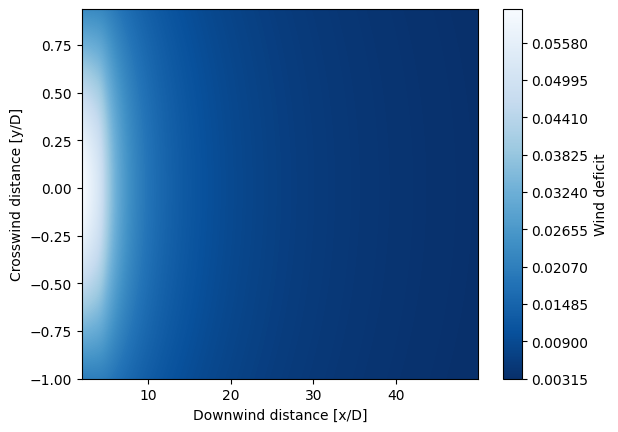

,TI,ct,WS_eff,TI_eff,WS,wind_deficit,x/D,y/D
0,0.5,0.429997,14.695507,0.520555,15,0.020300,2.0000,-1.0000
1,0.5,0.429997,14.652111,0.520555,15,0.023193,2.0000,-0.9375
2,0.5,0.429997,14.605932,0.520555,15,0.026271,2.0000,-0.8750
3,0.5,0.429997,14.557444,0.520555,15,0.029504,2.0000,-0.8125
4,0.5,0.429997,14.507244,0.520555,15,0.032850,2.0000,-0.7500
...,...,...,...,...,...,...,...,...
24571,0.5,0.429997,14.950551,0.500044,15,0.003297,49.9375,0.6875
24572,0.5,0.429997,14.950831,0.500044,15,0.003278,49.9375,0.7500
24573,0.5,0.429997,14.951133,0.500044,15,0.003258,49.9375,0.8125
24574,0.5,0.429997,14.951457,0.500044,15,0.003236,49.9375,0.8750


In [1]:
from data_loaders import *

folder = "data/discr_factors_x2_20_y-5_5_step0.125_TIstep0.01_CTstep0.01"

In [3]:
train_dl, valid_dl, test_dl = get_wake_dataloaders(folder, consider_ws=False, coords_as_input=False,
                                                   train_perc=0.5, validation_perc=0.2, test_perc=0.3)
print(len(train_dl))

17


In [4]:
train_dl, valid_dl, test_dl = get_wake_dataloaders(folder, consider_ws=False, coords_as_input=True,
                                                   train_perc=0.5, validation_perc=0.2, test_perc=0.3)
print(len(train_dl))

103200


In [2]:
train_dl, test_dl = get_wake_dataloaders(folder, consider_ws=True, coords_as_input=False)
print(len(train_dl))

: 

: 

In [ ]:
train_dl, test_dl = get_wake_dataloaders(folder, consider_ws=True, coords_as_input=True)
print(len(train_dl))

# Attempts to reduce resolution of the wake field

In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import utils

folder = "data/discr_factors_x2_50_y-1_1_step0.125_TIstep0.01_CTstep0.01"
filepath = os.path.join(folder, f"ws_{5}.nc")
ds = xr.open_dataset(filepath)
df = ds.to_dataframe()\
        .reset_index()\
        .rename(columns={"x:D": "x/D", "y:D": "y/D"})

#load_netcfd(folder, 5, True, combine_criterion="ananas") #filter_condition="ct > 0.5 and ti > 0.5 and xD > 10 and yD < 0")
df

,x/D,y/D,ti,ct,WS_eff,WS,wind_deficit
0,2.000,-1.000,0.00,0.10,4.994939,5,0.001012
1,2.000,-1.000,0.00,0.11,4.995646,5,0.000871
2,2.000,-1.000,0.00,0.12,4.996125,5,0.000775
3,2.000,-1.000,0.00,0.13,4.996456,5,0.000709
4,2.000,-1.000,0.00,0.14,4.996687,5,0.000663
...,...,...,...,...,...,...,...
52838395,49.875,0.875,0.99,0.91,4.965857,5,0.006829
52838396,49.875,0.875,0.99,0.92,4.965489,5,0.006902
52838397,49.875,0.875,0.99,0.93,4.965121,5,0.006976
52838398,49.875,0.875,0.99,0.94,4.964754,5,0.007049


In [3]:
import pandas as pd
import os
import xarray as xr
import numpy as np
from itertools import product

from utils.data_utils import load_netcfd

TI = "ti"
CT = "ct"
X_NC = "x:D"
Y_NC = "y:D"
X = "x/D"
Y = "y/D"

INPUT_VARIABLES = [TI, CT]
TRAINING_FACTOR = 4

FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"

df = load_netcfd(DATA_FOLDER, 12, include_ws_column=True)
df

,x/D,y/D,ti,ct,WS_eff,ws,wind_deficit
0,2.000,-2.000,0.00,0.10,12.000000,12,8.394138e-09
1,2.000,-2.000,0.00,0.11,12.000000,12,2.661650e-09
2,2.000,-2.000,0.00,0.12,12.000000,12,1.051978e-09
3,2.000,-2.000,0.00,0.13,12.000000,12,4.930828e-10
4,2.000,-2.000,0.00,0.14,12.000000,12,2.643731e-10
...,...,...,...,...,...,...,...
61644795,29.875,1.875,0.99,0.91,11.899764,12,8.352958e-03
61644796,29.875,1.875,0.99,0.92,11.898677,12,8.443586e-03
61644797,29.875,1.875,0.99,0.93,11.897590,12,8.534170e-03
61644798,29.875,1.875,0.99,0.94,11.896503,12,8.624709e-03


In [4]:
df[INPUT_VARIABLES].drop_duplicates().sort_values(by=INPUT_VARIABLES)

,ti,ct
0,0.00,0.10
1,0.00,0.11
2,0.00,0.12
3,0.00,0.13
4,0.00,0.14
...,...,...
8595,0.99,0.91
8596,0.99,0.92
8597,0.99,0.93
8598,0.99,0.94
